### Import Statements

In [1]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, SelectFromModel, SelectPercentile
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from mlxtend.feature_selection import ColumnSelector, SequentialFeatureSelector
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#from xgboost import XGBRegressor
import seaborn as sns

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ecbm4040/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Read the Data

In [3]:
data = pd.read_csv("../clean_data/FinalData_for_Models.csv")

In [4]:
data.rename(columns={'Unnamed: 0':'pickup_time'}, inplace=True)

In [5]:
data.head()

,pickup_time,num_pickups,num_passengers,missing_dt,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights
0,2014-01-01 00:00:00-05:00,107.0,210.0,False,269.27,267.59,270.93,80.0,3.0,clear,sky is clear,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 01:00:00-05:00,34.0,45.0,False,268.90,267.04,270.93,80.0,2.0,clear,sky is clear,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 02:00:00-05:00,34.0,70.0,False,268.48,266.48,270.37,57.0,3.0,clear,sky is clear,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 03:00:00-05:00,12.0,18.0,False,268.33,265.93,270.37,80.0,3.0,clear,sky is clear,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0
4,2014-01-01 04:00:00-05:00,25.0,37.0,False,268.10,265.37,270.37,80.0,3.0,clear,sky is clear,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0


In [6]:
## ignoring the missing data values in 2016
data = data.loc[data.missing_dt == False, :]
data.drop("missing_dt", axis=1, inplace=True)

In [7]:
data.shape

(30647, 20)

### Creating Dummies for Weather Data

In [8]:
## for weather main
data_wm_dummies = data['weather_main'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [9]:
## for weather description
data_wd_dummies = data['weather_description'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [10]:
data.drop(["weather_main", "weather_description"], axis=1, inplace=True)

In [11]:
data = pd.concat([data, data_wm_dummies], axis=1)

In [12]:
data.shape

(30647, 24)

In [13]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


** Remark : We can choose to only include weather main categories or weather description also alongwith <br> TRY BOTH OF THEM FOR MODELS **

### Modifying Boolean Data Columns (Holiday)

In [14]:
data['holiday'] = data.holiday.astype(int)

In [15]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Time Feature

In [16]:
data.rename(columns={'Hour':'HourOfDay'}, inplace=True)
data.rename(columns={'Day':'DayOfWeek'}, inplace=True)

In [17]:
data.head(2)

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


In [18]:
data.shape

(30647, 24)

### Quantile Cuts for Hour of Day to divide Hour of Days into 4 Main 6 Hour Categories

In [19]:
data['HourOfDay'] = pd.qcut(data['HourOfDay'], 4)

In [20]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Drop the Pickup Time and Number of Passengers

In [21]:
data.drop([
        "pickup_time",
        "num_passengers"], axis=1, inplace=True)

### Dropping cancelled arriving flights as they should have no influence in pickups at LGA

In [22]:
## as they will probably have no predictive value
data.drop(['Cancelled_Arriving_Flights'], axis=1, inplace=True)

### Last 2 hour Passengers (1 Hour Ago and 2 Hours Ago)

In [23]:
data['Prev_hour_Passengers'] = data['Passengers'].shift(1)
data['Prev_2hour_Passengers'] = data['Passengers'].shift(2)

In [24]:
data.Prev_hour_Passengers = data.Prev_hour_Passengers.fillna(method='bfill')
data.Prev_2hour_Passengers = data.Prev_2hour_Passengers.fillna(method='bfill')

### Dropping Temp_Mix and Temp_Max as we already have Temp

In [25]:
data.drop(['temp_min', 'temp_max'], axis=1, inplace=True)

### Converting Month and Day of Week to Categorical Data

In [26]:
data.Month = pd.Categorical(data.Month)
data.DayOfWeek = pd.Categorical(data.DayOfWeek)

In [27]:
data = pd.get_dummies(data)

In [28]:
data.head()

,num_pickups,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,"HourOfDay_(-0.001, 6.0]","HourOfDay_(6.0, 12.0]","HourOfDay_(12.0, 17.5]","HourOfDay_(17.5, 23.0]",DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,107.0,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,34.0,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,34.0,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,12.0,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,25.0,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


## MODELS FOLLOW FROM HERE

In [29]:
data.head()

,num_pickups,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,"HourOfDay_(-0.001, 6.0]","HourOfDay_(6.0, 12.0]","HourOfDay_(12.0, 17.5]","HourOfDay_(17.5, 23.0]",DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,107.0,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,34.0,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,34.0,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,12.0,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,25.0,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


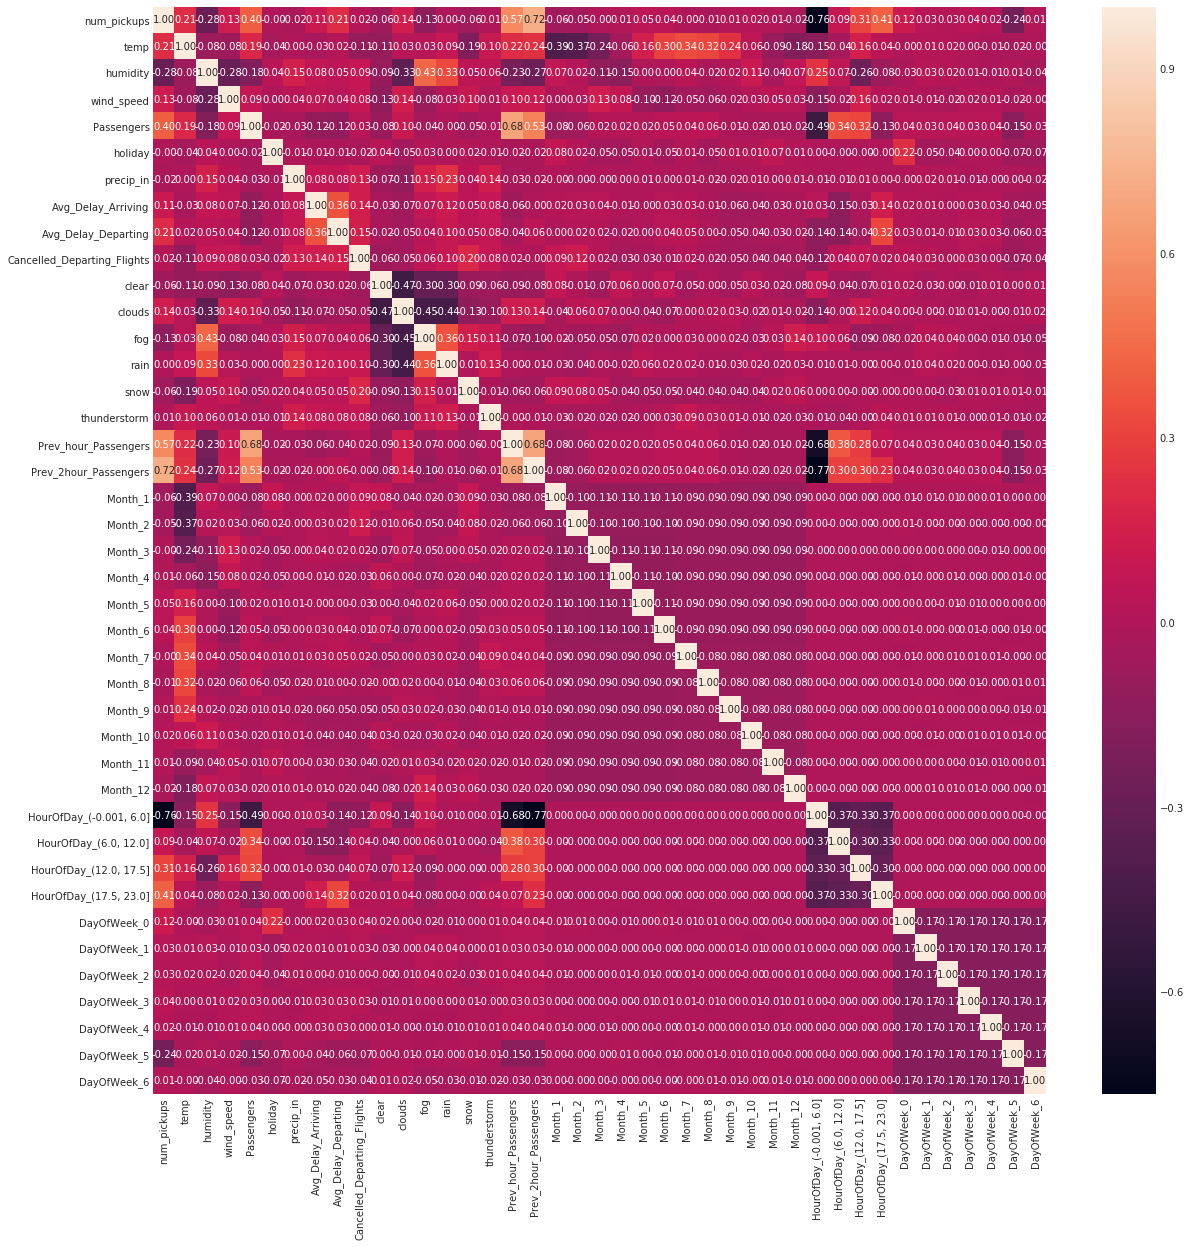

In [30]:
cor_scaler = StandardScaler()
data_scaled = cor_scaler.fit_transform(data)
plt.figure(figsize=(20,20))
sns.heatmap(pd.DataFrame(data_scaled, columns=data.columns).corr(),
           annot=True, fmt=".2f")

In [31]:
## the labels (num_pickups)
num_pickups = data.num_pickups
data.drop("num_pickups", axis=1, inplace=True)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data, num_pickups, random_state=0, test_size=0.15)

In [33]:
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

### Some functions

In [34]:
def get_predictions(X_train, y_train, X_test, classifier):
    classifier.fit(X_train, y_train)
    classifier.score(X_test, y_test)
    return classifier.predict(X_test)

In [35]:
def plot_errors_hour(data, predictions, y_test):
    test_hours = data['HourOfDay'].loc[y_test.index]
    errors_df = pd.DataFrame({'HourOfDay' : test_hours, 'y_test' : y_test, 'predictions' : predictions})
    errors_df['error'] = errors_df.predictions - errors_df.y_test
    errors_df['error frac'] = errors_df.error / errors_df.y_test
    errors_df_hourly = errors_df.groupby('HourOfDay').agg({'error' : 'mean', 'error frac' : 'mean'})
    errors_df_hourly.plot(kind = 'bar')
    return errors_df_hourly

### KNeighbors Regressor

In [43]:
KNN_pipe = make_pipeline(StandardScaler(), 
                         SequentialFeatureSelector(estimator=RidgeCV(), k_features='best', scoring='r2'), 
                         PolynomialFeatures(interaction_only=True), 
                         VarianceThreshold(), 
                         KNeighborsRegressor(n_jobs=-1))

KNN_param_grid = {
    'polynomialfeatures__degree': [2],
    'kneighborsregressor__n_neighbors': [5, 20],
    'kneighborsregressor__weights': ['uniform', 'distance'],
}

In [44]:
KNN_grid = GridSearchCV(KNN_pipe, KNN_param_grid, cv=5, scoring='r2', verbose=3, n_jobs=-1)
KNN_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] kneighborsregressor__n_neighbors=5, kneighborsregressor__weights=uniform, polynomialfeatures__degree=2 
[CV] kneighborsregressor__n_neighbors=5, kneighborsregressor__weights=uniform, polynomialfeatures__degree=2 
[CV] kneighborsregressor__n_neighbors=5, kneighborsregressor__weights=uniform, polynomialfeatures__degree=2 
[CV] kneighborsregressor__n_neighbors=5, kneighborsregressor__weights=uniform, polynomialfeatures__degree=2 
[CV] kneighborsregressor__n_neighbors=5, kneighborsregressor__weights=uniform, polynomialfeatures__degree=2 
[CV] kneighborsregressor__n_neighbors=5, kneighborsregressor__weights=distance, polynomialfeatures__degree=2 
[CV] kneighborsregressor__n_neighbors=5, kneighborsregressor__weights=distance, polynomialfeatures__degree=2 
[CV] kneighborsregressor__n_neighbors=5, kneighborsregressor__weights=distance, polynomialfeatures__degree=2 
[CV] kneighborsregressor__n_neighbors=5, kneighborsregressor__wei

KeyboardInterrupt: 

## Model_Ridge : Ridge Regression

In [40]:
select_lassocv = SelectFromModel(LassoCV(), threshold="median")
ridge_pipe = make_pipeline(StandardScaler(), select_lassocv, PolynomialFeatures(interaction_only=True),
                           VarianceThreshold(), Ridge())
ridge_params = {'ridge__alpha' : [0.01, 0.1, 1.0, 10.0, 100.0, np.log(14)],
                'polynomialfeatures__degree' : [2, 3]}

In [54]:
ridge_grid = GridSearchCV(ridge_pipe, ridge_params, cv=5, scoring='r2', verbose=3, n_jobs=-1)

In [55]:
ridge_grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialf

[Parallel(n_jobs=-1)]: Done  34 out of  60 | elapsed:  1.3min remaining:   59.5s


[CV]  polynomialfeatures__degree=3, ridge__alpha=1.0, score=0.6920658633480757, total=  32.2s
[CV] polynomialfeatures__degree=3, ridge__alpha=2.63905732962 ........
[CV]  polynomialfeatures__degree=3, ridge__alpha=10.0, score=0.7731814807332836, total=  31.9s
[CV] polynomialfeatures__degree=3, ridge__alpha=2.63905732962 ........
[CV]  polynomialfeatures__degree=3, ridge__alpha=10.0, score=0.7966605996588849, total=  46.7s
[CV]  polynomialfeatures__degree=3, ridge__alpha=1.0, score=0.7963440263202232, total=  55.5s
[CV]  polynomialfeatures__degree=3, ridge__alpha=10.0, score=0.7215931608662844, total=  35.2s
[CV]  polynomialfeatures__degree=3, ridge__alpha=10.0, score=0.7871485540977703, total=  36.8s
[CV]  polynomialfeatures__degree=3, ridge__alpha=100.0, score=0.7611727525416994, total=  29.9s
[CV]  polynomialfeatures__degree=3, ridge__alpha=100.0, score=0.782442778992642, total=  32.1s
[CV]  polynomialfeatures__degree=3, ridge__alpha=100.0, score=0.7944703789995013, total=  30.5s
[CV

[Parallel(n_jobs=-1)]: Done  55 out of  60 | elapsed:  2.5min remaining:   13.9s


[CV]  polynomialfeatures__degree=3, ridge__alpha=0.01, score=0.7681574519133159, total= 2.2min
[CV]  polynomialfeatures__degree=3, ridge__alpha=10.0, score=0.7701411444128177, total= 1.9min
[CV]  polynomialfeatures__degree=3, ridge__alpha=1.0, score=0.7683475267421747, total= 2.0min
[CV]  polynomialfeatures__degree=3, ridge__alpha=100.0, score=0.783926841133593, total= 1.6min
[CV]  polynomialfeatures__degree=3, ridge__alpha=2.63905732962, score=0.768668400566609, total= 1.4min


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectfrommodel', SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='aut...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 2.6390573296152584], 'polynomialfeatures__degree': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [58]:
ridge_grid.best_params_

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10.0}

In [59]:
ridge_grid.best_score_

0.7966569404213073

In [61]:
joblib.dump(ridge_grid.best_estimator_, "gridSearch_Models/model_ridge.pkl")

['gridSearch_Models/model_ridge.pkl']

## Model_SVR : SVR

In [62]:
svr_pipe = make_pipeline(StandardScaler(), VarianceThreshold(), SVR())
svr_params = {'svr__kernel' : ['rbf', 'sigmoid'],
             'svr__C' : [0.01, 0.1, 1.0, 10.0, 100.0],
             'svr__epsilon' : [0.01, 0.05, 0.1, 0.2, 0.5]}
svr_grid = GridSearchCV(svr_pipe, svr_params, cv=5, scoring='r2', verbose=2, n_jobs=-1)

In [63]:
svr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=sigmoid .............
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=sigmoid .............
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=sigmoid .............
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=sigmoid .............
[CV] svr__C=0.01, svr__epsilon=0.01, svr__kernel=sigmoid .............
[CV] svr__C=0.01, svr__epsilon=0.05, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.05, svr__kernel=rbf .................
[CV] svr__C=0.01, svr__epsilon=0.05, svr__kernel=rbf .................
[CV] svr__C=0.0

[CV] svr__C=0.1, svr__epsilon=0.05, svr__kernel=sigmoid ..............
[CV]  svr__C=0.01, svr__epsilon=0.5, svr__kernel=sigmoid, total= 1.6min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf ...................
[CV]  svr__C=0.01, svr__epsilon=0.5, svr__kernel=sigmoid, total= 1.6min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf ...................
[CV]  svr__C=0.01, svr__epsilon=0.5, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf ...................
[CV]  svr__C=0.01, svr__epsilon=0.5, svr__kernel=sigmoid, total= 1.4min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf ...................
[CV] ... svr__C=0.1, svr__epsilon=0.05, svr__kernel=rbf, total= 1.3min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf ...................
[CV] ... svr__C=0.1, svr__epsilon=0.01, svr__kernel=rbf, total= 1.5min
[CV] svr__C=0.1, svr__epsilon=0.1, svr__kernel=sigmoid ...............
[CV]  svr__C=0.1, svr__epsilon=0.01, svr__kernel=sigmoid, total= 1.4min
[

KeyboardInterrupt: 

In [ ]:
svr_grid.best_score_

In [ ]:
joblib.dump(svr_grid.best_estimator_, "gridSearch_Models/model_svr.pkl")

### Random Forest

In [83]:
rf_pipe = make_pipeline(RandomForestRegressor(n_jobs=-1))
rf_params = {'randomforestregressor__n_estimators' : [50, 100, 200], 
             'randomforestregressor__max_features' : ["auto", "sqrt", "log2"],
             'randomforestregressor__max_depth' : [5, 9, 11, 15, 17, 21],
#              'randomforestregressor__criterion' : ['mae', 'mse'],
             'randomforestregressor__warm_start' : [True]
}
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=5, scoring='r2', verbose=5, n_jobs=-1)

In [84]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100,

[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, score=0.790354760135752, total=   4.1s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, score=0.7912383301895782, total=   4.2s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestreg

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.7649308771789372, total=   4.2s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.7822090798993051, total=   7.1s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregre

[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, score=0.8200436241189157, total=   2.5s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, score=0.8152047935109641, total=   2.2s
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, score=0.8279222398085223, total=   4.7s
[CV] randomforestregressor__max_depth=9, randomforestregress

[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, score=0.8081837713035908, total=   3.1s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=9, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8194068740561983, total=   6.8s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestre

[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, score=0.8341448881096731, total=   3.1s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, score=0.8386549107953604, total=   8.4s
[CV] randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomfore

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   36.8s


[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8355768419808625, total=   7.9s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.835830494574447, total=   7.9s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, score=0.8316927917937819, total=   4.1s
[CV] randomforestregressor__max_depth=15, randomforest

[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8447949672004076, total=  24.5s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8453694405291586, total=  24.3s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomfo

[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, score=0.8493277398062823, total=   5.1s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8437230516336862, total=  10.6s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8531805315791287, total=  10.7s
[CV] randomforestregressor__max_depth=17, randomfores

[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, score=0.8555990480676885, total=  13.5s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8583042442054806, total=  33.4s
[CV] randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomfor

[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8576086166981771, total=  11.1s
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8487350463187682, total=  10.6s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8558226997819243, total=  10.9s
[CV] randomforestregressor__max_depth=21, randomfores

[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, score=0.8573881217393708, total=   5.2s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True, score=0.8561518973529619, total=  13.7s
[CV] randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=17, randomforestregressor__max_features=auto, randomfore

[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8566007587573273, total=  12.5s
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8577127839798038, total=  12.6s
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8607501793235968, total=  13.7s
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, score=0.8592090407547106, total=   6.6s
[CV]  randomforestregressor__max_depth=21, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, score=0.85

[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'randomforestregressor__n_estimators': [50, 100, 200], 'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 'randomforestregressor__max_depth': [5, 9, 11, 15, 17, 21], 'randomforestregressor__warm_start': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=5)

In [85]:
rf_grid.best_score_

0.85750342090728926

In [86]:
rf_grid.best_params_

{'randomforestregressor__max_depth': 21,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__n_estimators': 200,
 'randomforestregressor__warm_start': True}

In [87]:
joblib.dump(rf_grid.best_estimator_, "gridSearch_Models/model_rf.pkl")

['gridSearch_Models/model_rf.pkl']

### Gradient Boosting Regressor

In [99]:
gbt_pipe = make_pipeline(GradientBoostingRegressor(random_state=0))
gbt_params = {'gradientboostingregressor__n_estimators' : [50, 100, 200],
              'gradientboostingregressor__max_features' : ["auto", "sqrt"],
#              'gradientboostingregressor__subsample' : [0.2, 0.5, 1.0],
              'gradientboostingregressor__max_depth' : [5, 10, 15],
              'gradientboostingregressor__warm_start' : [False]
             }

gbt_grid = GridSearchCV(gbt_pipe, gbt_params, cv=5, scoring='r2', verbose=3, n_jobs=-1)

In [100]:
gbt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_de

[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, score=0.8466459405836975, total=   3.6s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, score=0.8524015172902835, total=   5.0s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV]  gradie

[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, score=0.8516456470257348, total=  11.8s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, score=0.858353221226626, total=  26.4s
[CV] gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, score=0.862

[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, score=0.8591617348979144, total= 1.4min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradientboostingregressor__max_depth=10, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False, score=0.861406736448033, total= 1.5min
[CV] gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV]  gradi

[Parallel(n_jobs=-1)]: Done  74 out of  90 | elapsed:  4.4min remaining:   57.6s


[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, score=0.8409522393044644, total= 3.7min
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, score=0.8463605727584549, total= 3.7min
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, score=0.8609121494602631, total= 1.6min
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, score=0.8632925860091061, total= 2.2min
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingr

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min...ors=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gradientboostingregressor__n_estimators': [50, 100, 200], 'gradientboostingregressor__max_features': ['auto', 'sqrt'], 'gradientboostingregressor__max_depth': [5, 10, 15], 'gradientboostingregressor__warm_start': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [101]:
gbt_grid.best_params_

{'gradientboostingregressor__max_depth': 10,
 'gradientboostingregressor__max_features': 'sqrt',
 'gradientboostingregressor__n_estimators': 200,
 'gradientboostingregressor__warm_start': False}

In [102]:
gbt_grid.best_score_

0.8656520267323643

In [103]:
joblib.dump(gbt_grid.best_estimator_, "gridSearch_Models/model_gbt_warmNo.pkl")

['gridSearch_Models/model_gbt_warmNo.pkl']

## Decision Tree Regressor

## XGBoost Regressor

In [112]:
X_train.rename(columns={'HourOfDay_(-0.001, 6.0]':'first6', 'HourOfDay_(6.0, 12.0]':'6to12', 
                       'HourOfDay_(12.0, 17.5]': '12to18', 'HourOfDay_(17.5, 23.0]': '18to24'}, inplace=True)

/home/ecbm4040/miniconda3/envs/ml/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [113]:
X_train.head()

,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,first6,6to12,12to18,18to24,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
4536,296.75,78.0,6.0,0.0,0,0.0,188.125000,0.000000,0.0,0,1,0,0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
21071,295.65,61.0,2.0,0.0,0,0.0,110.500000,71.000000,0.0,0,0,0,1,0,0,0.0,87.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
16132,282.45,76.0,1.0,0.0,0,0.0,0.000000,0.000000,0.0,0,0,1,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
24852,285.56,50.0,1.0,532.0,0,0.0,2.235294,3.733333,0.0,0,1,0,0,0,0,299.0,765.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
16125,286.44,48.0,1.0,447.0,0,0.0,16.684211,9.375000,0.0,0,0,1,0,0,0,693.0,1188.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0


In [46]:
n_estimators = [50, 100, 200]
max_depth = [5, 7]
learning_rate = [0.1]
subsample = [1.0]
colsample_bytree = [0.7]
colsample_bylevel = [0.6]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]
param_grid = dict(xgbregressor__n_estimators=n_estimators, 
                  xgbregressor__max_depth=max_depth, 
                  xgbregressor__learning_rate=learning_rate, 
                  xgbregressor__subsample=subsample, 
                  xgbregressor__colsample_bytree=colsample_bytree, 
                  xgbregressor__colsample_bylevel=colsample_bylevel,
                  xgbregressor__gamma=gamma
                 )
xgb_pipe = make_pipeline(XGBRegressor())
xgb_grid = GridSearchCV(xgb_pipe, param_grid=param_grid, cv=5, scoring='r2', verbose=3, n_jobs=-1)

In [122]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbr

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.8468883749791303, total=  24.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.8550747425119667, total=  24.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsam

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.857233920973764, total=  50.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.8438811475312165, total=  30.0s
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, score=0.858839233400780

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.8422847738102861, total=  16.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.8373058962266486, total=  17.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsa

[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.857233920973764, total=  52.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsamp

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.836013497389038, total=  15.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, score=0.8586299196557188, total= 1.6min
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__cols

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  2.8min


[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, score=0.8603998481851565, total= 1.5min
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, score=0.8513402759537356, total= 1.0min
[CV] xgbregressor__cols

[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.8454877799785535, total=  33.8s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.850993974896148, total=  42.9s
[CV] xgbregressor__colsam

[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, score=0.8634562140701942, total= 1.6min
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_

[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.836013497389038, total=  16.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.8373058962266486, total=  19.4s
[CV] xgbregressor__colsam

[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.8586161076882383, total=  50.2s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.8438811475312165, total=  30.4s
[CV] xgbregressor__col

[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.8532933126521874, total=  49.7s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.5, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, score=0.8681900525730456, total= 1.6min
[CV] xgbregressor__col

[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.8498227027601147, total=  26.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.8454877799785535, total=  34.3s
[CV] xgbregressor__cols

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.6, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, score=0.8681900525730456, total= 1.6min
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.7, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, score=0.8540874914014316, total= 1.1min
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV] xgbregressor__col

[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.8468883749791303, total=  27.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.8513866723797633, total=  30.1s
[CV] xgbregressor__colsamp

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.8572338943827014, total=  49.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.8, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, score=0.8588392334007808, total= 1.1min
[CV] xgbregressor__colsa

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  8.2min


[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.850993974896148, total=  34.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.8550747425119667, total=  25.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__cols

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.8532933126521874, total=  51.5s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.8627413828018929, total=  54.3s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__co

[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.850993974896148, total=  39.9s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.8550747425119667, total=  26.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=1.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__cols

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('xgbregressor', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'xgbregressor__n_estimators': [50, 100, 200], 'xgbregressor__max_depth': [5, 7], 'xgbregressor__learning_rate': [0.1], 'xgbregressor__subsample': [1.0], 'xgbregressor__colsample_bytree': [0.7], 'xgbregressor__colsample_bylevel': [0.6], 'xgbregressor__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [123]:
xgb_grid.best_score_

0.86382908730863817

In [124]:
xgb_grid.best_params_

{'xgbregressor__colsample_bylevel': 0.6,
 'xgbregressor__colsample_bytree': 0.7,
 'xgbregressor__gamma': 1.1,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 7,
 'xgbregressor__n_estimators': 200,
 'xgbregressor__subsample': 1.0}

### MLXTEND

In [37]:
from mlxtend.regressor import StackingCVRegressor, StackingRegressor
from sklearn.pipeline import Pipeline

In [42]:
ridge_pipe_mlxtend = make_pipeline(StandardScaler(), select_lassocv, PolynomialFeatures(interaction_only=True, degree=2),
                           VarianceThreshold(), Ridge(alpha=10.0))

In [43]:
rf_mlxtend = RandomForestRegressor(max_depth=21, max_features='auto', n_estimators=200, warm_start=True)

In [44]:
gbt_mlxtend = GradientBoostingRegressor(max_depth=10, max_features='sqrt', n_estimators=200, warm_start=False)

In [52]:
#xgb_mlxtend = XGBRegressor(colsample_bylevel==0.6, colsample_bytree=0.7, gamma=1.1, learning_rate=0.1, max_depth=7,
                          n_estimators=200, subsample=1.0)

TypeError: __init__() got multiple values for argument 'max_depth'

In [53]:
lasso = LassoCV(max_iter=20000)
stack_pipe = make_pipeline(StackingCVRegressor(regressors = [ridge_pipe_mlxtend, rf_mlxtend, gbt_mlxtend], 
                            meta_regressor=lasso))

In [54]:
# stack_param_grid2 = {
#                     'stackingcvregressor__ridge__alpha' : [x/5.0 for x in range(1, 10)],
#                     'stackingcvregressor__lasso__alpha' : [x/20.0 for x in range(1, 10)],
#                     'stackingcvregressor__lasso__max_iter' : [5000],
#                     'stackingcvregressor__randomforestregressor__n_estimators' : [10, 25, 100],
#                     'stackingcvregressor__randomforestregressor__max_depth' : [10, 25, 100, None],
#                     'stackingcvregressor__meta-lasso__alpha' : [x/20.0 for x in range(1, 10)],
#                     'stackingcvregressor__use_features_in_secondary' : [True, False]
# }
stack_param_grid2={}

In [55]:
grid_pipe = GridSearchCV(estimator = stack_pipe, param_grid = stack_param_grid2, cv = 5, refit = True, verbose=2, scoring = 'r2')

In [ ]:
grid_pipe.fit(X_train_np, y_train_np)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


/home/ecbm4040/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ecbm4040/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
